The goal of this notebook is to try some experiments to assess the baseline performance of single task (city) performance on post COVID data. This gives us an indication on what to improve upon.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.utils.validation import check_X_y, check_array
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor

In [2]:
def get_col_names():
    df = pd.read_csv("Data_Processed_New/NYISO_mobility_annotated.csv")
    df_cols = np.array(df.columns)
    
    response_col_name = df_cols[1]
    weather_col_names = df_cols[2:7]
    timestamp_col_names = df_cols[12:43]
    holiday_col_names = [df_cols[43]]
    mobility_col_names = df_cols[44:53]
    
    return response_col_name, weather_col_names, timestamp_col_names, holiday_col_names, mobility_col_names

In [3]:
response_col_name, weather_col_names, timestamp_col_names, holiday_col_names, mobility_col_names = get_col_names()

In [4]:
# The city_name field can take on "Boston", "Chicago", "Dallas", "Houston", "Phil", "SA", or "Seattle".
def load_data(city_name, standardize = False, verbose = False, no_mobility = False):
    df = np.genfromtxt('Data_Processed_New/City_Level/%s_mobility_all.csv' % city_name, delimiter=',')
    
    X_weather = df[:, 1:1+len(weather_col_names)].astype(float)
    X_holiday = df[:, 1+len(holiday_col_names)+len(weather_col_names)+len(timestamp_col_names)].astype(float).reshape(-1, 1)
    X_mobility = df[:, 1+len(holiday_col_names)+len(weather_col_names)+len(timestamp_col_names):].astype(float)    
    if no_mobility:
        X = np.hstack((X_weather, X_holiday))
    else:
        X = np.hstack((X_weather, X_holiday, X_mobility))
    
    if standardize: X = scale(X)
    
    timestamps = df[:, 1+len(weather_col_names):1+len(weather_col_names)+len(timestamp_col_names)].astype(int)
    y = df[:, 0].astype(float)
    
    metadata = {"city_name" : city_name, 
                "X_weather" : X_weather, 
                "X_holiday": X_holiday,
                "X_mobility" : X_mobility, 
                "timestamps" : timestamps}

    if verbose:
        print(city_name, "Energy Consumption Data:")
        print("Sample size n =", X.shape[0])
        print("Number of weather features d_w =", X_weather.shape[1])
        print("Number of holiday features d_h =", X_holiday.shape[1])
        if not no_mobility:
            print("Number of mobility features d_m =", X_mobility.shape[1])
        print("Total number features d =", X.shape[1])
    
    return X, y, metadata

In [5]:
X, y, metadata = load_data("Boston", verbose = True, no_mobility = True)

Boston Energy Consumption Data:
Sample size n = 2184
Number of weather features d_w = 5
Number of holiday features d_h = 1
Total number features d = 6


In [6]:
# This function adds past output values as inputs. 'p' is the number of lagged values to append.
# 'ps' is an array of lags. 'scales' is an array which determines the intervals of those lags.
def append_past_outputs(X, y, p_hour, p_day, p_week):
    X, y = check_X_y(X, y)
    if p_hour == 0 and p_day == 0 and p_week == 0:
        return X, y
    
    hour_time = 1
    day_time = int(hour_time * 24)
    week_time = int(day_time * 7)
    
    ps = [int(p_hour), int(p_day), int(p_week)]
    times = [hour_time, day_time, week_time]
    burnin = int(max(np.array(ps) * np.array(times)))
    
    n = len(X)
    n_new = n - burnin
    X_new = X[burnin:]
    y_new = y[burnin:]
    
    # Make numpy array of indices, and use it to index/map y.
    # i is the training example, j is the lag.
    for p in range(3):
        if ps[p] != 0:
            idx = np.fromfunction(lambda i, j: burnin + i - times[p]*(j + 1), (n_new, ps[p]), dtype = np.int32)
            X_new = np.hstack((X_new, y[idx]))
    
    return X_new, y_new

In [7]:
# This function adds past output values as inputs. 'p' is the number of lagged values to append.
# 'ps' is an array of lags. 'scales' is an array which determines the intervals of those lags.
def append_past_inputs(X, y, p_hour, p_day, p_week):
    X, y = check_X_y(X, y)
    if p_hour == 0 and p_day == 0 and p_week == 0:
        return X, y
    
    hour_time = 1
    day_time = int(hour_time * 24)
    week_time = int(day_time * 7)
    
    ps = [int(p_hour), int(p_day), int(p_week)]
    times = [hour_time, day_time, week_time]
    burnin = int(max(np.array(ps) * np.array(times)))
    
    n = len(X)
    n_new = n - burnin
    X_new = X[burnin:]
    y_new = y[burnin:]
    
    # add hourly features from up to p_hour lags ago.
    if p_hour != 0:
        d = X_new.shape[1]
        X_hour = np.zeros((n_new, int(p_hour)*d))
        for i in range(n_new):
            for j in range(int(p_hour)):
                for k in range(d):
                    X_hour[i, j*d+k] = X[burnin + i - (j + 1), k]
        X_new = np.hstack((X_new, X_hour))
    
    # Make numpy array of indices, and use it to index/map y.
    # i is the training example, j is the lag.
    for p in range(1, 3):
        if ps[p] != 0:
            idx = np.fromfunction(lambda i, j: burnin + i - times[p]*(j + 1), (n_new, ps[p]), dtype = np.int32)
            X_new = np.hstack((X_new, y[idx]))
    
    return X_new, y_new

In [8]:
# Test append past values.
n = 300
d = 2

X = np.hstack((np.arange(n).reshape((n,1)), np.ones((n, 1))))
y = np.arange(n)

p_hour = 3
p_day = 2
p_week = 1

X, y = append_past_inputs(X, y, p_hour, p_day, p_week)

print("Expected X size = (132, 11)")
print("Observed X size =", X.shape)

print("Expected y size = (132,)")
print("Observed y size =", y.shape)

print("Expected X[0] = [168. 1. 167. 1. 166. 1. 165. 1. 144. 120. 0.]")
print("Observed X[0] =", X[0])

Expected X size = (132, 11)
Observed X size = (132, 11)
Expected y size = (132,)
Observed y size = (132,)
Expected X[0] = [168. 1. 167. 1. 166. 1. 165. 1. 144. 120. 0.]
Observed X[0] = [168.   1. 167.   1. 166.   1. 165.   1. 144. 120.   0.]


In [9]:
# Because the data are time series, this can only be done with one fold.
def train_val_test_split(X, y):
    X, y = check_X_y(X, y)
    
    n = len(y)
    n_train = int(0.8 * n)
    n_val = (n - n_train) // 2
    n_test = n - n_train - n_val
    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# Test append past values.
n = 50
d = 10
X = np.zeros((n, d))
y = np.arange(n)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)

print("Expected y_test = [45 46 47 48 49]")
print("Observed y_test =", y_test)

Expected y_test = [45 46 47 48 49]
Observed y_test = [45 46 47 48 49]


In [11]:
# generate hyper parameters array
def sample_hyperparams(num_settings):
    hyperparams = np.zeros((num_settings, 4))
    for i in range(num_settings):
        
        hyperparams[i, 0] = 10 ** np.random.uniform(-3, 1) # regularization param
        # hyperparams[i, 1] = np.random.randint(9) # p_hour
        hyperparams[i, 2] = np.random.randint(6) # p_day
        hyperparams[i, 3] = np.random.randint(3) # p_day
    
    return hyperparams

Expected shape of hyperparams = (100, 4)
Observed shape of hyperparams = (100, 4)
[6.98213488e-03 2.44352772e+00 4.83400453e+00 1.23135815e-01
 1.54238555e-03 1.73344255e-03 3.97197165e-03 7.37929482e+00
 1.39640627e-02]

 Plot should be discrete uniform over [0, 2], [0, 5], [0, 8], respectively


Text(0.5, 1.0, 'Distribution of SAR lags')

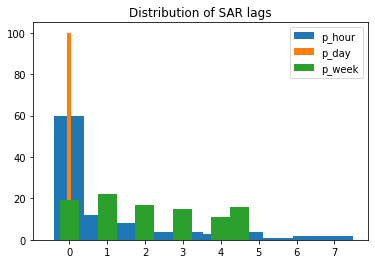

In [12]:
num_settings = 100
hyperparams = sample_hyperparams(num_settings)

print("Expected shape of hyperparams = (100, 4)")
print("Observed shape of hyperparams =", hyperparams.shape)

# Check lambdas for log scale
print(hyperparams[1:10, 0])

# Check for uniformity.
print("\n Plot should be discrete uniform over [0, 2], [0, 5], [0, 8], respectively")
scales = ["p_hour", "p_day", "p_week"]
for i in range(3):
    plt.hist(hyperparams[:, i], label = scales[i], align = 'left')
plt.legend()
plt.title("Distribution of SAR lags")

In [13]:
def fit_model(model_name, X_train, y_train, lambda_):
    if model_name == 'rf':
        model = RandomForestRegressor(n_estimators=300)
        return model.fit(X_train, y_train)
    else:
        model = Ridge(alpha=lambda_)
        return model.fit(X_train, y_train)

# relative error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_pred = check_array(y_pred, ensure_2d=False)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def compute_error(model, X_val, y_val):
    X_val, y_val = check_X_y(X_val, y_val)
    y_pred = model.predict(X_val)
    return mean_absolute_percentage_error(y_val, y_pred)

def compute_cheat_test_error(model_name, X, y, hyperparams):
    lambda_, p_hour, p_day, p_week = hyperparams["lambda"], hyperparams["p_hour"], hyperparams["p_day"], hyperparams["p_week"] 
    
    X_aug, y_aug = append_past_outputs(X, y, p_hour, p_day, p_week)
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_aug, y_aug)
    
    X_full = np.vstack((X_train, X_val))
    y_full = np.concatenate((y_train, y_val))
    model = fit_model(model, X_full, y_full, lambda_)
    
    return compute_error(model, X_test, y_test), model

In [14]:
# Test rel_Error
y_pred = np.array([0, 1, 2, 3])
y_true = np.array([1, 1, 1, 1])
rel_err = mean_absolute_percentage_error(y_true, y_pred)

print("Expected relative error = 1.0")
print("Observed relative error =", rel_err)

# "Test" linear
X = np.random.randn(10, 3)
y = X[:, 0]
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)
model = fit_model('ridge', X_train, y_train, 0.0)
print("Expected relative error is very small.")
print("Observed relative error is", compute_error(model, X_val, y_val))

Expected relative error = 1.0
Observed relative error = 1.0
Expected relative error is very small.
Observed relative error is 1.1724925517371533e-15


Computing test error is a little bit tricky, as we will not have access to all of the features on the onset. Instead, we will need to predict them 24 hours in advance, and use the predictions as features for future predictions.

In [15]:
def compute_test_error(model_name, X, y, hyperparams):
    lambda_, p_hour, p_day, p_week = hyperparams["lambda"], hyperparams["p_hour"], hyperparams["p_day"], hyperparams["p_week"] 
    
    d = X.shape[1]
    X_aug, y_aug = append_past_outputs(X, y, p_hour, p_day, p_week)
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_aug, y_aug)
    
    X_retrain = np.vstack((X_train, X_val))
    y_retrain = np.concatenate((y_train, y_val))
    model = fit_model(model_name, X_retrain, y_retrain, lambda_)
                
    return backtest_error(model, X_aug, y_test, p_hour, d), model

def backtest_error(model, X_aug, y_test, p_hour, d):
    # Compute error.
    n_aug, d_aug = X_aug.shape
    n_test = len(y_test)
    n_retrain = n_aug - n_test
    y_pred = np.zeros(n_test)
    X = np.copy(X_aug) 
    for i in range(n_test):
        # Index in time.
        t = i + n_retrain
        y_pred[i] = model.predict(X[t].reshape(1, -1))
        
        # Populate predictions.
        for p in range(int(p_hour)):
            if t + p < n_aug and d + p < d_aug:
                X[t + p, d + p] = y_pred[i]
    
    return mean_absolute_percentage_error(y_test, y_pred)

In [16]:
# Test backtest
class TestModel():
    def __init__(self, p_hour):
        self.p_hour = p_hour
    def predict(self, X):
        X = check_array(X)
        return X[:, self.p_hour] + X[:, self.p_hour + 1]

p_hour = 2
n = 5
d = 2
n_test = 3

X_aug = np.hstack((np.zeros((n, d)), np.fromfunction(lambda i, j: i, (n, p_hour))))
y_test = np.ones(n_test)
model = TestModel(p_hour)

err = backtest_error(model, X_aug, y_test, p_hour, d)

# y_0 = 1; yhat_0 = X_2[2] + X_3[3] = 2 + 2 = 4. error = 3 / 1 = 3
# y_1 = 1; yhat_1 = X_3[2] + X_3[3] = yhat_0 + X_3[3] = 4 + 3 = 7. error = 6 / 1 = 6
# y_2 = 1; yhat_2 = X_4[2] + X_4[3] = yhat_1 + X_4[3] = 7 + 4 = 11. error = 10 / 1 = 10
# avg = 19/3

print("Expected error =", 19/3)
print("Observed error =", err)

Expected error = 6.333333333333333
Observed error = 6.333333333333333


In [21]:
def run_experiment(city_name, num_settings, model_name, no_mobility = False):
    X, y, metadata = load_data(city_name, standardize = True, verbose = False, no_mobility = no_mobility)
    hyperparams = sample_hyperparams(num_settings)

    def worker(row):
        # Collect hyperparameters.
        lambda_, p_hour, p_day, p_week = row
        
        # Build features.
        X_aug, y_aug = append_past_outputs(X, y, p_hour, p_day, p_week)
        
        # Latest timesteps are test, second latest are validation, rest is train.
        X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_aug, y_aug)
        
        # Compute validation error.
        model = fit_model(model_name, X_train, y_train, lambda_)
        rel_err = compute_error(model, X_val, y_val)

        return rel_err

    # non parallel version
#     rel_errs = np.zeros(num_settings)
#     for s in range(num_settings):
#         rel_errs[s] = worker(hyperparams[s])
        
    rel_errs = np.array(Parallel(n_jobs=-2)(delayed(worker)(row) for row in hyperparams))
    
    argmin = np.argmin(rel_errs)
    best_val_error = rel_errs[argmin]
    best_hyperparams = {
        "lambda" : hyperparams[argmin, 0],
        "p_hour" : hyperparams[argmin, 1],
        "p_day" : hyperparams[argmin, 2],
        "p_week" : hyperparams[argmin, 3]
    }
    
    print("City:", city_name)
    if no_mobility:
        print("No mobility features used.")
    print("Best relative validation error:", best_val_error)
    print("Best hyperparmeters:")
    print(best_hyperparams)
    print("model:", model_name)
    
    # Compute test loss error.
    test_error, model = compute_test_error(model_name, X, y, best_hyperparams)
    print("Test error: ", test_error)
    
    result = {
        'model' : model,
        'best_val_error' : best_val_error,
        'best_hyperparams' : best_hyperparams,
        'test_error' : test_error
    }
    return result

In [22]:
city_name = "Seattle"
num_settings = 100
model_name = 'ridge'
no_mobility = True

result = run_experiment(city_name, num_settings, model_name, no_mobility = no_mobility)

City: Seattle
No mobility features used.
Best relative validation error: 0.03862828435955593
Best hyperparmeters:
{'lambda': 0.0015532228836670863, 'p_hour': 0.0, 'p_day': 5.0, 'p_week': 0.0}
model: ridge
Test error:  0.044520386310836275


In [24]:
city_name = "Boston"
num_settings = 100
model_name = 'ridge'
no_mobility = True

result = run_experiment(city_name, num_settings, model_name, no_mobility = no_mobility)

City: Boston
No mobility features used.
Best relative validation error: 0.03289964629910225
Best hyperparmeters:
{'lambda': 1.0485716889386631, 'p_hour': 0.0, 'p_day': 3.0, 'p_week': 2.0}
model: ridge
Test error:  0.04465882536550039


In [25]:
city_name = "SA"
num_settings = 40
model_name = 'ridge'
no_mobility = True

result = run_experiment(city_name, num_settings, model_name, no_mobility = no_mobility)

City: SA
No mobility features used.
Best relative validation error: 0.06025330553247977
Best hyperparmeters:
{'lambda': 0.006702660078940776, 'p_hour': 0.0, 'p_day': 4.0, 'p_week': 1.0}
model: ridge
Test error:  0.0999791822785781


In [26]:
city_name = "Houston"
num_settings = 40
model_name = 'ridge'
no_mobility = False

result = run_experiment(city_name, num_settings, model_name, no_mobility = no_mobility)

City: Houston
Best relative validation error: 0.042110193605167844
Best hyperparmeters:
{'lambda': 0.011697476571696886, 'p_hour': 0.0, 'p_day': 1.0, 'p_week': 0.0}
model: ridge
Test error:  0.10953733875783513


In [27]:
city_name = "Chicago"
num_settings = 40
model_name = 'ridge'
no_mobility = True

result = run_experiment(city_name, num_settings, model_name, no_mobility = no_mobility)

City: Chicago
No mobility features used.
Best relative validation error: 0.028571289272884545
Best hyperparmeters:
{'lambda': 0.06339070472897894, 'p_hour': 0.0, 'p_day': 4.0, 'p_week': 1.0}
model: ridge
Test error:  0.041161566939127425
